In [1]:
import pandas as pd
import numpy as np
import nltk
import operator
import math
import collections
#from hermetrics.levenshtein import Levenshtein
from nltk.corpus import stopwords # stopwords
import re
from nltk.util import bigrams # Use of bigrams
from nltk.stem import PorterStemmer #Steaming

import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('../../data/tweets.csv')

# Exploration

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   298 non-null    object
 1   senti   298 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.8+ KB


In [4]:
df.senti.unique()

array([0, 4, 2])

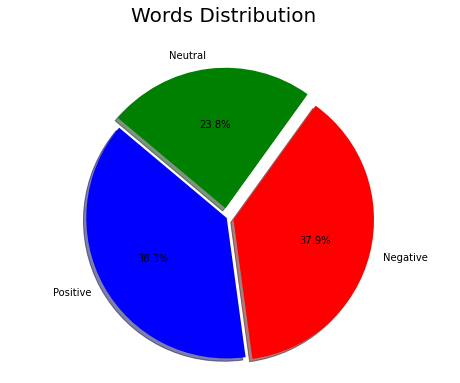

In [5]:
fig= plt.figure(figsize=(8,6))

neutral = 0
positive = 0
negative = 0
for value in df.senti:
    if value ==2:
        neutral+=1
    elif value ==4:
        positive+=1
    else:
        negative+=1
        
labels = ['Positive', 'Negative', 'Neutral']
sizes = [positive, negative, neutral]
colors = ['blue', 'red', 'green']
# Data to plot
explode = (0, 0.05, 0.07)  # explode 1st slice
fig.suptitle('Words Distribution', fontsize=20)

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

We can see the classes are a little bit unbalanced

In [7]:
neutral = []
positive = []
negative = []
for i,value in enumerate(df.senti):
    if value == 2:
        neutral.append(len(df.tweet[i]))
    elif value ==4:
        positive.append(len(df.tweet[i]))
    else:
        negative.append(len(df.tweet[i]))
        

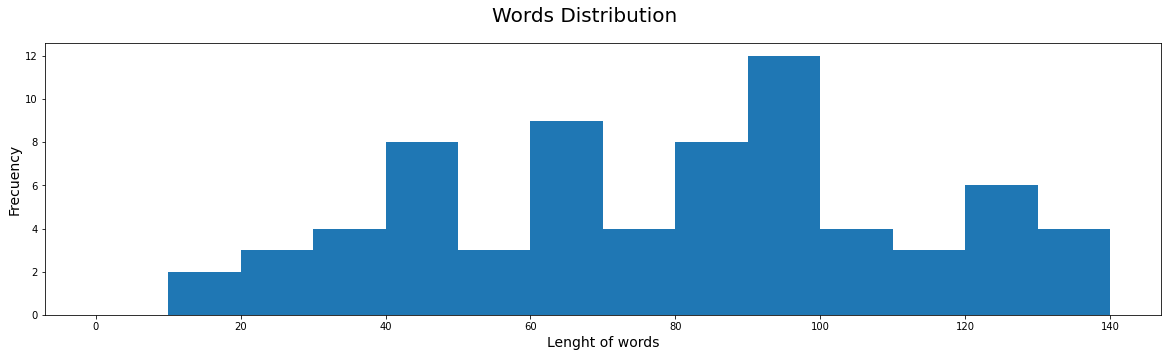

In [8]:
fig= plt.figure(figsize=(20,5))
fig.suptitle('Words Distribution', fontsize=20)
plt.xlabel('Lenght of words', fontsize=14)
plt.ylabel('Frecuency', fontsize=14)
plt.hist(neutral,bins = np.arange(0,150,10))#(0,1300,5)
plt.show()

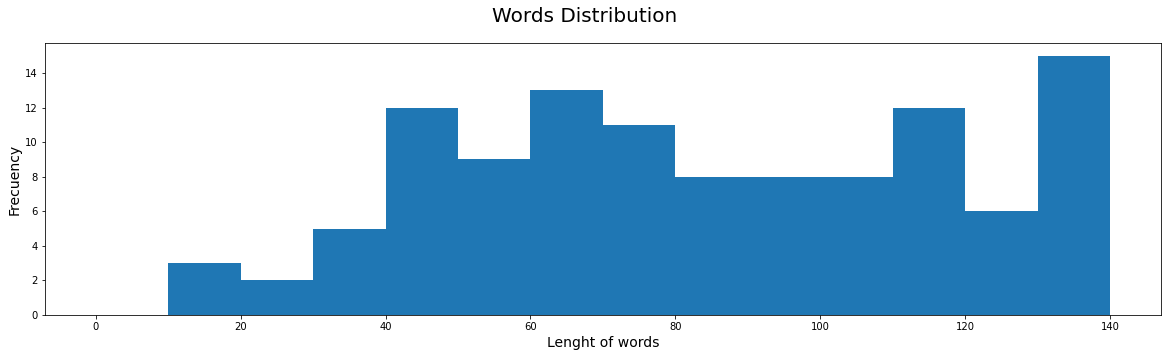

In [9]:
fig= plt.figure(figsize=(20,5))
fig.suptitle('Words Distribution', fontsize=20)
plt.xlabel('Lenght of words', fontsize=14)
plt.ylabel('Frecuency', fontsize=14)
plt.hist(positive,bins = np.arange(0,150,10))#(0,1300,5)
plt.show()

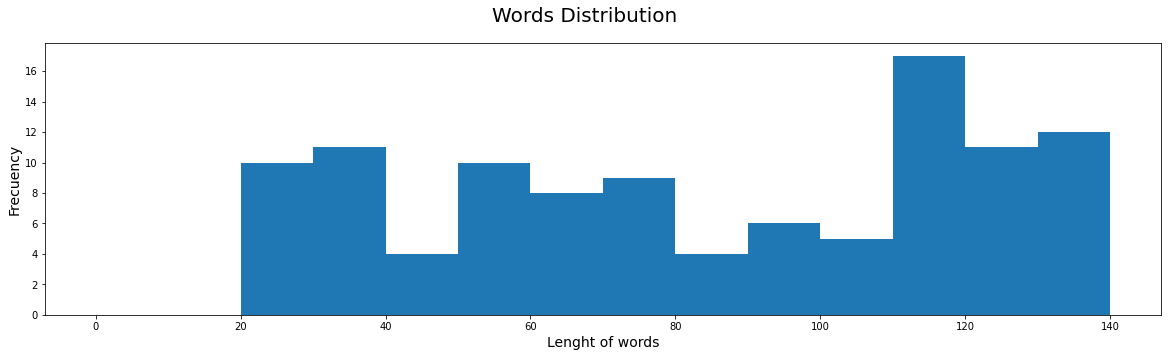

In [10]:
fig= plt.figure(figsize=(20,5))
fig.suptitle('Words Distribution', fontsize=20)
plt.xlabel('Lenght of words', fontsize=14)
plt.ylabel('Frecuency', fontsize=14)
plt.hist(negative,bins = np.arange(0,150,10))#(0,1300,5)
plt.show()

In [11]:
### we didn't find representative differences in the range of the distribution between the lenght of words for the 3 classes to be included in the classification

# Preprocessing

In [192]:
class preprocessing(object):
    def __init__(self,special_chars):
        self.special_chars = special_chars

    def cleanString(self,s):
        s=s.lower()
        s=self.normalization(s)
        # remove special chars
        for char in special_chars:
            s = s.replace(char, "")
        s = s.replace("\\n", " ").replace("\n", " ")
        tokenizer = nltk.tokenize.TweetTokenizer()
        # Remove stop words
        stop_words = set(stopwords.words('english'))
        cleaned_words = [w for w in tokenizer.tokenize(s) if w not in stop_words]
        return " ".join(cleaned_words)

    def normalization(self,s):
        # remove numbers
        s = re.sub(r"\d+", "", s)
        s=re.sub("&amp", "&", s)
        s=re.sub("&quot", "", s)
        s=re.sub("&lt", "<", s)
        # Substitute users
        s=re.sub('@\S+', "user", s)
        # Substitute links
        s=re.sub('h[\S]+//[\S]+', "link", s)

        return "".join(s)
    #We add a new column names clean_comment, we'll be working with this one
    def cleanFrame(selfdev,frame):
        frame['clean_comment'] = frame.tweet.apply(selfdev.cleanString)
special_chars = "?;!¬-\''=().,"

Preprocessing=preprocessing(special_chars)
Preprocessing.cleanFrame(df)

In [117]:
df

,tweet,senti,clean_comment
0,"@united Oh, we are sure it's not planned, but ...",0,user oh sure planned occurs absolutely consist...
1,History exam studying ugh,0,history exam studying ugh
2,@unnitallman yeah looks like that only! &quot;...,0,user yeah looks like busy fucking yeah gf
3,Loves twitter,4,loves twitter
4,@Mbjthegreat i really dont want AT&amp;T phone...,0,user really dont want & phone servicethey suck...
...,...,...,...
293,@criticalpath Such an awesome idea - the cont...,4,user awesome idea continual learning program k...
294,"Talk is Cheap: Bing that, I?ll stick with Goog...",0,talk cheap : bing ill stick google link
295,@CTesdahl well you can always digg or stumble....,4,user well always digg stumbleboth aided greatl...
296,Stopped to have lunch at McDonalds. Chicken Nu...,4,stopped lunch mcdonalds chicken nuggetssss : y...


# Lexical analysis and POS tagging

In [14]:
class POS_tagging:
    # Here we get all the lexico
    def Lexicon(self, tokens, Lexico):
        for word in tokens:
            if word in Lexico.keys():
                Lexico[word] += 1
            else:
                Lexico[word] = 1
        return Lexico
    # We calculate the probability of every item in the lexico, based on the frequency
    def prob_lexico(self,Lexico):
        lexicoTemp=Lexico
        Lexico_lenght=sum(lexicoTemp.values())
        for words in lexico:
            lexicoTemp[words]=lexicoTemp[words]/Lexico_lenght
        return lexicoTemp
    # assign the tags
    def pos_tag(self,Cleaned):
        POS,Token=[],[]
        for tweet in Cleaned:
            pos_token = nltk.pos_tag(tweet.split())
            POS.append(pos_token[0][1])
        return POS
    # Bigrams and probabilities of the chains method
    def lexicon(self,POS_tag):
        Lexico = {}
        Total=0
        for bigram in list(bigrams(POS_tag)):
            if bigram in Lexico.keys():
                    Lexico[bigram] += 1
            else:
                Lexico[bigram] = 1
            Total+=1
        for i in Lexico.keys():
            Lexico[i]= Lexico[i]/Total
            
        sorted_lexico = sorted(Lexico.items(), key=operator.itemgetter(1), reverse=True)
        return sorted_lexico

In [119]:
Lexical_analysis=POS_tagging()
tokenizer = nltk.tokenize.TweetTokenizer()
lexico={}
POS_tag=[]
for t in df["clean_comment"]:
    t=list(t)
    tokens = tokenizer.tokenize(("".join(t)))
    lexico.update(Lexical_analysis.Lexicon(tokens,lexico))
    temp_pos=Lexical_analysis.pos_tag(tokens) # assign the tags by nlkt
    POS_tag+=temp_pos
bagWords=lexico.copy()
lexico_prob=Lexical_analysis.prob_lexico(lexico) #Probability of a word to appear in the lexico
bigram_prob=Lexical_analysis.lexicon(POS_tag)

# Classes

Now we are going to devide the set by classes, so we can work with the documents for the classes in separate way

In [16]:
def makingClasses(df):
    Positive = df[df.senti == 4]
    Negative = df[df.senti == 0]
    Neutral = df[df.senti == 2]
    total_data = len(df)
    def printDFrame(name, frame, total_data):
        print(name + ": " + str(frame.shape[0]) + " " + str(frame.shape[0]/total_data * 100) + "%")
    p = printDFrame
    p("Positive", Positive, total_data)
    p("Negative", Negative, total_data)
    p("Neutral", Neutral, total_data)
    return Positive, Negative, Neutral
def LexicoClass(data):
    lexico={}
    for document in data:
        tokens = tokenizer.tokenize((" ".join(document)))
        for word in tokens:
            if word in lexico.keys():
                lexico[word] += 1
            else:
                lexico.update({word:1})
    return lexico

In [17]:
Positive, Negative, Neutral = makingClasses(df)

Positive: 114 38.25503355704698%
Negative: 113 37.919463087248324%
Neutral: 71 23.825503355704697%


In [18]:
df.senti.value_counts()


4    114
0    113
2     71
Name: senti, dtype: int64

As we have few data, to banlance the classses, we are going to make the three classes with the size of the largest class

In [19]:
maxlen=len(Positive)
Negative = Negative.append(Negative.sample(maxlen-len(Negative)))
Neutral = Neutral.append(Neutral.sample(maxlen-len(Neutral)))

In [20]:
lexicoPos={}
lexicoNeg={}

for t in Positive.clean_comment:
    t=list(t)
    tokens = tokenizer.tokenize(("".join(t)))
    lexicoPos.update(Lexical_analysis.Lexicon(tokens,lexicoPos))
for t in Negative.clean_comment:
    t=list(t)
    tokens = tokenizer.tokenize(("".join(t)))
    lexicoNeg.update(Lexical_analysis.Lexicon(tokens,lexicoNeg))

In [24]:
BagOfWords= set(lexicoPos).union(set(lexicoNeg))
DicPos = dict.fromkeys(BagOfWords, 0) 
DicNeg = dict.fromkeys(BagOfWords, 0)
for word in lexicoPos:
    DicPos[word]+=1
    
for word in lexicoNeg:
    DicNeg[word]+=1

In [25]:
def TF(D, lexico):
    lexico_len = len(lexico)
    tf = {}
    for word, count in D.items():
        tf[word] = count / float(lexico_len)
    return tf
def IDF(D):
    N = len(D)
    IDF = dict.fromkeys(D[0].keys(), 0)
    for document in D:
        for word, val in document.items():
            if val > 0:
                IDF[word] += 1
    for word, val in IDF.items():
        IDF[word] = math.log(N / float(val))
    return IDF
def TFIDF(D, idf):
    tf_idf = {}
    for word, val in D.items():
        tf_idf[word] = val * idf[word]
    return tf_idf

In [27]:
tfPos = TF(DicPos, BagOfWords)
tfNeg = TF(DicNeg, BagOfWords)
IDF = IDF([DicPos, DicNeg])

TFIDF_pos = TFIDF(tfPos, IDF)
TFIDF_neg = TFIDF(tfNeg, IDF)

In [194]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(df.clean_comment.tolist())
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
tfidf = pd.DataFrame(denselist, columns=feature_names)

In [35]:
tfidf

,aapl,absolutely,accept,acceptable,access,accidentally,accompaniments,account,acg,activated,...,youve,yummmmmy,yung,yyj,zydrunas,ºðÿ,âœœï,ðÿ,ðÿœžðÿ,œuser
0,0.0,0.260577,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.294565,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
294,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
295,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
296,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.422249,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(tfidf, df.senti)


In [199]:
clf.score(tfidf, df.senti)

0.9899328859060402